In [9]:
from utils import get_amazon_importance
from pathlib import Path
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.style.use('fivethirtyeight')

In [55]:
model_basename = "opt-13b"
prune_method = "imbalanced_correct"
prune_task = "hellaswag"
metric = "cosine"
group_metric = "cosine"
prune_percents = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75]
metric_path = metric + "_" + group_metric
amazon_list = get_amazon_importance()
amazon_list.sort(key=lambda x: x[2], reverse = True)
amazon_list = [(x[0], x[1]) for x in amazon_list]
amazon_top_n = [100, 200, 300, 800]

result_dict = defaultdict(list)
for top_n in amazon_top_n:
    amazon_heads = amazon_list[:top_n]
    
    for prune_percent in prune_percents:
        number_pruned = 0
        path_log = Path("pruning_logs") / model_basename / prune_method / prune_task / metric_path / str(prune_percent) / "pruning_log.txt"
        pruning_log = []
        with open(path_log, "r") as f:
            lines = f.readlines()
            for line in lines:
                layer, head_to_keep, head_to_prune = map(int, line.strip().split(","))
                pruning_log.append((layer, head_to_prune))
        for pruned_head in pruning_log:
            if pruned_head in amazon_heads:
                number_pruned += 1
        result_dict[f"top {top_n}"].append(round(number_pruned/top_n,2))

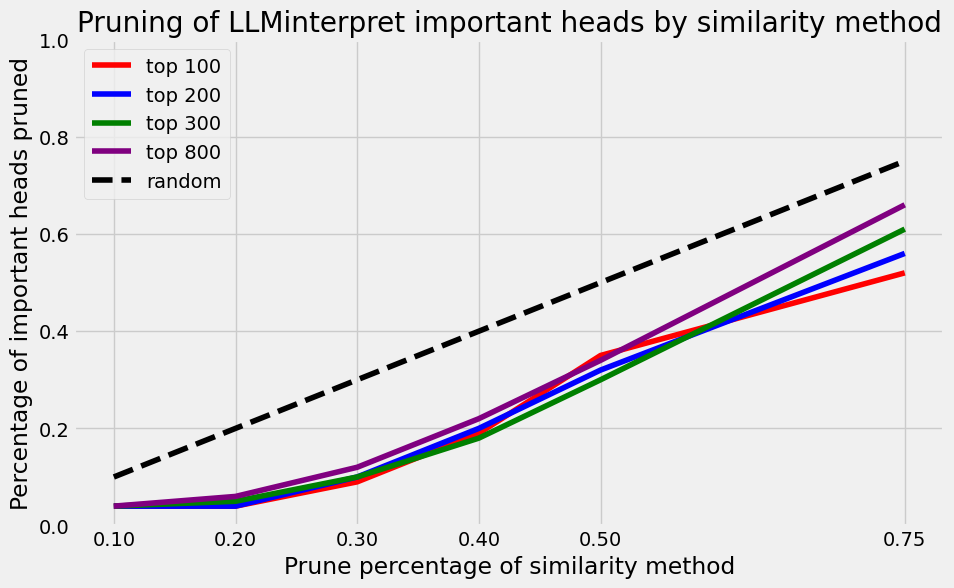

In [56]:

plt.figure(figsize=(10, 6))
colors = {"top 100": "red",
    "top 200": "blue",
    "top 300": "green",
    "top 800": "purple",
    "top 50" : "yellow",
 }
for label, y in result_dict.items():
    for label_c, color in colors.items():
        if label_c in label:
            sns.lineplot(x=prune_percents, y=y, label=label, color=color)
sns.lineplot(x=prune_percents, y=prune_percents, label="random", color="black", linestyle='dashed')
plt.xticks(prune_percents)
plt.title('Pruning of LLMinterpret important heads by similarity method')
plt.xlabel('Prune percentage of similarity method')
plt.ylabel('Percentage of important heads pruned')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [52]:
amazon_list = get_amazon_importance()
amazon_list.sort(key=lambda x: x[2])
amazon_list = [(x[0], x[1]) for x in amazon_list]
results = []
for prune_percent in prune_percents:
    heads_to_prune= int(prune_percent*1600)
    amazon_heads = amazon_list[:heads_to_prune]
    number_pruned = 0
    path_log = Path("pruning_logs") / model_basename / prune_method / prune_task / metric_path / str(prune_percent) / "pruning_log.txt"
    pruning_log = []
    with open(path_log, "r") as f:
        lines = f.readlines()
        for line in lines:
            layer, head_to_keep, head_to_prune = map(int, line.strip().split(","))
            pruning_log.append((layer, head_to_prune))
    for pruned_head in pruning_log:
        if pruned_head in amazon_heads:
            number_pruned += 1
    results.append(round(number_pruned/heads_to_prune,2))

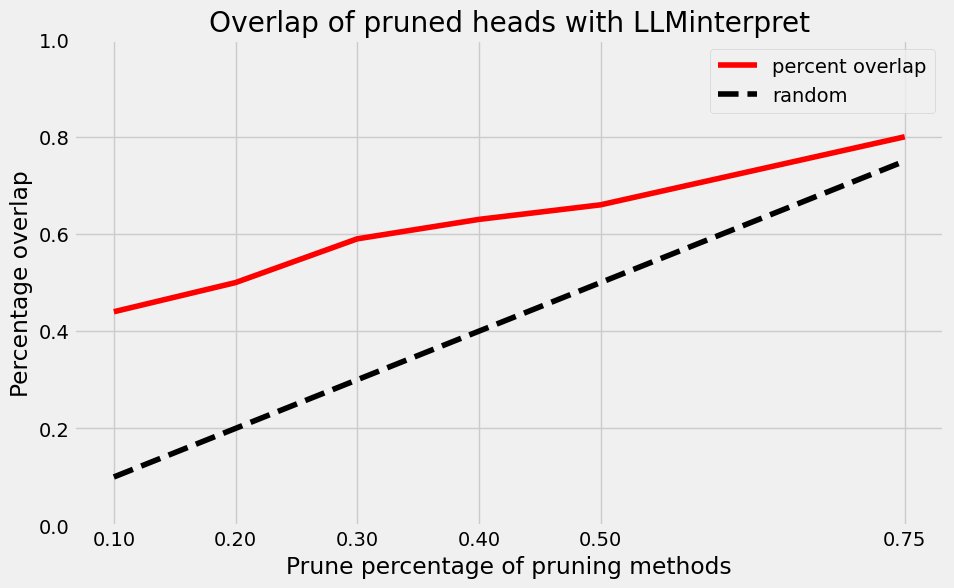

In [54]:

plt.figure(figsize=(10, 6))


sns.lineplot(x=prune_percents, y=results, label="percent overlap", color="red")
sns.lineplot(x=prune_percents, y=prune_percents, label="random", color="black", linestyle='dashed')
plt.xticks(prune_percents)
plt.title('Overlap of pruned heads with LLMinterpret')
plt.xlabel('Prune percentage of pruning methods')
plt.ylabel('Percentage overlap')
plt.ylim(0, 1)
plt.legend()
plt.show()